# Sentiment Analysis: Naive Bayes
I will be implementing logistic regression for sentiment analysis on tweets. Given a tweet, I will decide if it has a positive sentiment or a negative one. I will be using a data set of tweets.

The main features of this project are:

* Train a naive bayes model on a sentiment analysis task
* Test using the trained model
* Compute ratios of positive words to negative words
* Error Analysis to identify misclassifications
* Predict on custom tweets

In [8]:
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_recall_curve,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt

In [9]:
from utils import process_tweet, lookup
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd

In [10]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [11]:
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

In [12]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

In [13]:
tweets = all_positive_tweets + all_negative_tweets

positive_labels = [1] * len(all_positive_tweets)
negative_labels = [0] * len(all_negative_tweets)

labels = positive_labels + negative_labels


# For test dataset only
test_pos_labels = [1] * len(test_pos)
test_neg_labels = [0] * len(test_neg)

test_labels = test_pos_labels + test_neg_labels

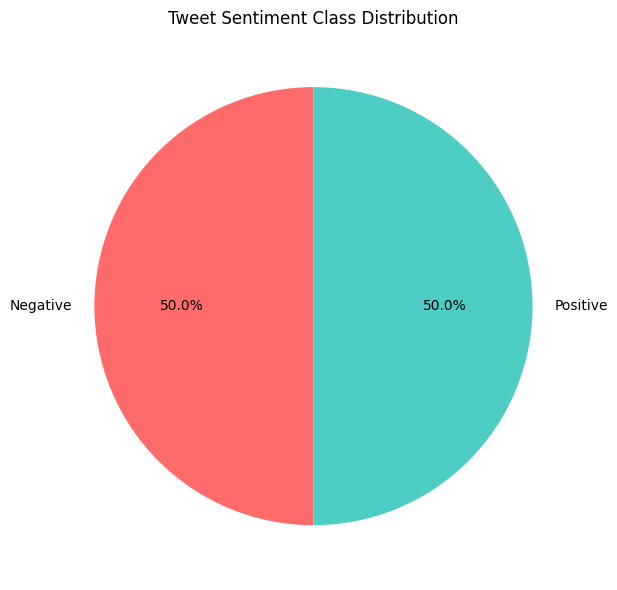

In [14]:
"""
Pie chart of class distribution
"""

plt.figure(figsize=(8, 6))
class_counts = pd.Series(labels).value_counts()
plt.pie(class_counts, labels=['Negative', 'Positive'], startangle=90,
        autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'])
plt.title('Tweet Sentiment Class Distribution')
plt.tight_layout()

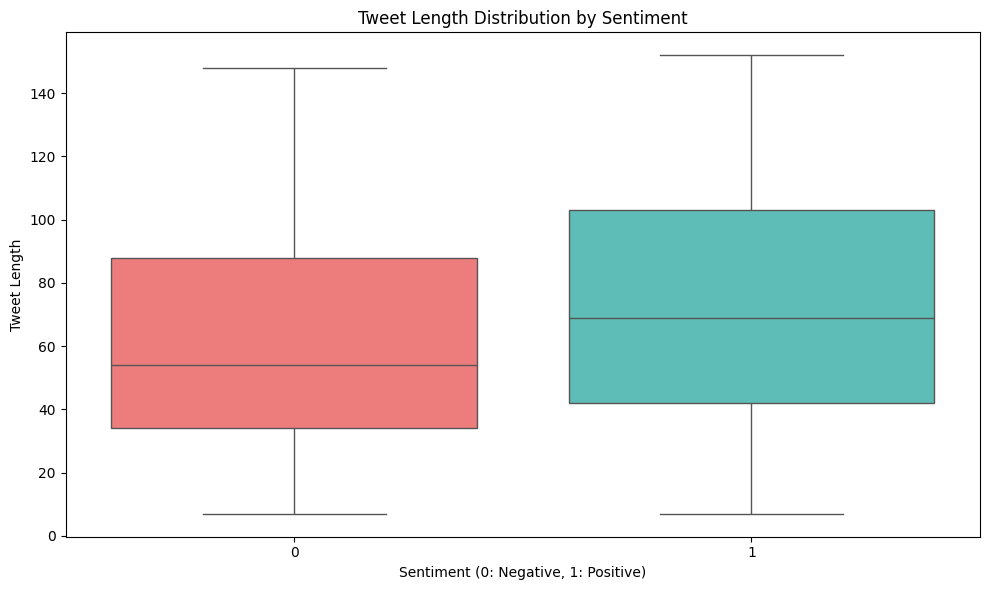

In [15]:
"""
Box plot of tweet lengths by sentiment
"""
tweet_lengths = [len(tweet) for tweet in tweets]

plt.figure(figsize=(10, 6))
sns.boxplot(x=labels, y=tweet_lengths, 
            palette=['#FF6B6B', '#4ECDC4'])
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Tweet Length')
plt.tight_layout()

# Step 1: Data Processing

Data Processing steps involve:

- Remove Noise, useless special characters, and punctuations
- Perform stemming to only keep track of one variation of each word

`process_tweet()` function from the utility file is responsible for tweet processing

In [16]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

# print cleaned tweet
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


`count_tweets()` function takes a list of tweets as input, cleans all of them, and returns a dictionary.

- The key in the dictionary is a tuple containing the stemmed word and its class label, e.g. ("happi",1).
- The value the number of times this word appears in the given collection of tweets (an integer).

In [17]:
def count_tweets(result, tweets, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            # define the key, which is the word and label tuple
            pair = (word,y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1

    return result

In [18]:
# Testing the function

result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

# Step 2: Model Training

When using Naive Bayes for Sentiment Analysis, it takes a short time to train and also has a short prediction time.

#### Naive Bayes classifier Training Steps?
- Identify the number of classes that you have.
- Create a probability for each class.

$P(D_{pos})$ is the probability that the document is positive.
$P(D_{neg})$ is the probability that the document is negative.
Use the formulas as follows and store the values in a dictionary:

$$P(D_{pos}) = \frac{D_{pos}}{D}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}$$

Where $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

#### Prior and Logprior

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and I call this the logprior

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$

It can be simplified to:

$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})$$

#### Positive and Negative Probability of a Word
To compute the positive and negative probability for a specific word, I am using this formula:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

Notice that I added the "+1" in the numerator for additive smoothing.

#### Log likelihood

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

##### `freqs` dictionary
- Given the `count_tweets()` function, I compute a dictionary called `freqs` that contains all the frequencies.
- In this `freqs` dictionary, the key is the tuple (word, label)
- The value is the number of times it has appeared.

I will use this dictionary in several parts later.

In [19]:
# Build the freqs dictionary for later uses

freqs = count_tweets({}, train_x, train_y)

### Training Part of Naive Bayes Classifier

Given a freqs dictionary, `train_x` (a list of tweets) and a `train_y` (a list of labels for each tweet), I will implement a naive bayes classifier.

In [20]:
D_pos = []
for x, y in zip(train_x, train_y):
    if y == 1:
        D_pos.append(x)

print(len(D_pos))

4000


In [21]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_x)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = [x for x, y in zip(train_x, train_y) if y == 1]
    D_pos = len(D_pos)

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = [x for x, y in zip(train_x, train_y) if y == 0]
    D_neg = len(D_neg)

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)


    return logprior, loglikelihood


In [22]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9161


# Step 3: Model (Naive Bayes) Testing


#### `naive_bayes_predict` function

* The function takes in the `tweet`, `logprior`, `loglikelihood`.
* It returns the probability that the tweet belongs to the positive or negative class.
* For each tweet, I sum up loglikelihoods of each word in the tweet.
* Also I add the logprior to this sum to get the predicted sentiment of that tweet.

$$ p = logprior + \sum_i^N (loglikelihood_i)$$

In [23]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]


    return p


In [24]:
# Experiment with a custom tweet.
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.557492820301094


In [25]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.abs(y_hats - test_y)) 

    # Accuracy is 1 minus the error
    accuracy = 1 - error


    return accuracy


In [40]:
print(f"Naive Bayes accuracy = {round(test_naive_bayes(test_x, test_y, logprior, loglikelihood) * 100, 2)} %")

Naive Bayes accuracy = 99.55 %


In [27]:

# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
#     print(f'{tweet} -> {p:.2f} ({p_category})')
    print(f'{tweet} -> {p:.2f}')

I am happy -> 2.14
I am bad -> -1.31
this movie should have been great. -> 2.12
great -> 2.13
great great -> 4.26
great great great -> 6.39
great great great great -> 8.52


In [28]:
# Feel free to check the sentiment of your own custom tweet below!!!
my_tweet = 'no you did not predict right'
naive_bayes_predict(my_tweet, logprior, loglikelihood)

np.float64(-0.7895013479391699)

# Step 4: Filtering words by Ratio of positive to negative counts

- Some words have more positive counts than others, and can be considered "more positive".  Likewise, some words can be considered more negative than others.
- One way I figured to define the level of positiveness or negativeness, without calculating the log likelihood, is to compare the positive to negative frequency of the word.
- I calculate the ratio of positive to negative frequencies of a word.
- Once I have these ratios, I can also filter a subset of words that have a minimum ratio of positivity / negativity or higher.
- Similarly, I can also filter a subset of words that have a maximum ratio of positivity / negativity or lower (words that are at least as negative, or even more negative than a given threshold).

#### `get_ratio()` function
- Given the `freqs` dictionary of words and a particular word, I use `lookup(freqs,word,1)` to get the positive count of the word.
- Similarly, I use the `lookup()` function to get the negative count of that word.
- Calculate the ratio of positive divided by negative counts

<table>
    <tr>
        <td>
            <b>Words</b>
        </td>
        <td>
        Positive word count
        </td>
         <td>
        Negative Word Count
        </td>
  </tr>
    <tr>
        <td>
        glad
        </td>
         <td>
        41
        </td>
    <td>
        2
        </td>
  </tr>
    <tr>
        <td>
        arriv
        </td>
         <td>
        57
        </td>
    <td>
        4
        </td>
  </tr>
    <tr>
        <td>
        :(
        </td>
         <td>
        1
        </td>
    <td>
        3663
        </td>
  </tr>
    <tr>
        <td>
        :-(
        </td>
         <td>
        0
        </td>
    <td>
        378
        </td>
  </tr>
</table>

In [29]:
def get_ratio(freqs, word):
    '''
    Input:
        freqs: dictionary containing the words
        word: string to lookup

    Output: a dictionary with keys 'positive', 'negative', and 'ratio'.
        Example: {'positive': 10, 'negative': 20, 'ratio': 0.5}
    '''
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    # use lookup() to find positive counts for the word (denoted by the integer 1)
    pos_neg_ratio['positive'] = lookup(freqs,word,1)

    # use lookup() to find negative counts for the word (denoted by integer 0)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1) / (pos_neg_ratio['negative'] + 1)
    return pos_neg_ratio


In [30]:
get_ratio(freqs, 'happi')

{'positive': 162, 'negative': 18, 'ratio': 8.578947368421053}

In [31]:
def get_words_by_threshold(freqs, label, threshold):
    '''
    Input:
        freqs: dictionary of words
        label: 1 for positive, 0 for negative
        threshold: ratio that will be used as the cutoff for including a word in the returned dictionary
    Output:
        word_set: dictionary containing the word and information on its positive count, negative count, and ratio of positive to negative counts.
        example of a key value pair:
        {'happi':
            {'positive': 10, 'negative': 20, 'ratio': 0.5}
        }
    '''
    word_list = {}

    for key in freqs.keys():
        word, _ = key

        # get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs, word)

        # if the label is 1 and the ratio is greater than or equal to the threshold...
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # If the label is 0 and the pos_neg_ratio is less than or equal to the threshold...
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # otherwise, do not include this word in the list (do nothing)

    return word_list


In [32]:
# Test your function: find negative words at or below a threshold
get_words_by_threshold(freqs, label=0, threshold=0.05)

{':(': {'positive': 1, 'negative': 3675, 'ratio': 0.000544069640914037},
 ':-(': {'positive': 0, 'negative': 386, 'ratio': 0.002583979328165375},
 'zayniscomingbackonjuli': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '26': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 '>:(': {'positive': 0, 'negative': 43, 'ratio': 0.022727272727272728},
 'lost': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '♛': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 '》': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 'beli̇ev': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'wi̇ll': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'justi̇n': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｓｅｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｍｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776}}

In [33]:
# Test your function; find positive words at or above a threshold
get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2960, 'negative': 2, 'ratio': 987.0},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':d': {'positive': 523, 'negative': 0, 'ratio': 524.0},
 ':p': {'positive': 105, 'negative': 0, 'ratio': 106.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 552, 'negative': 0, 'ratio': 553.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative': 4, 'ratio': 11.6},
 'glad': {'positive': 41, 'negative': 2, 'ratio': 14

Notice the difference between the positive and negative ratios. Emojis like :( and words like 'me' tend to have a negative connotation. Other words like 'glad', 'community', and 'arrives' tend to be found in the positive tweets.

# Step 5: Error Analysis

In [34]:
# Some error analysis 
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b'truli later move know queen bee upward bound movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
1	0.00	b'harri niall 94 harri born ik stupid wanna chang :d'
1	0.00	b'park get sunlight'
1	0.00	b'uff itna miss karhi thi ap :p'
0	1.00	b'hello info possibl interest jonatha close join beti :( great'
0	1.00	b'u prob fun david'
0	1.00	b'pat jay'
0	1.00	b'sr financi analyst expedia inc bellevu wa financ expediajob job job hire'


# Step 6: Make Predictions with your own custom tweet 

### for the viewers!! :)



In [48]:
# Test with your own tweet - feel free to modify `my_tweet`
my_tweet = 'thank you for viewing this project'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(f'Prediction: {p}')
if np.sign(p) > 0:
    print(f'Sentiment: {np.sign(p)} -> Postitive')
else:
    print(f'Sentiment: {0} -> Negative')


Prediction: 2.925098248121496
Sentiment: 1.0 -> Postitive
